In [1]:
import pandas as pd

df = pd.read_csv("fisheries_with_pace_rrs_avw.csv")
print(df.columns)

Index(['TOWDATETIME_EST', 'LAT', 'LON', 'MEAN_DEPTH', 'SWEPT_AREA_km',
       'acadian redfish', 'alewife', 'alligatorfish', 'american lobster',
       'american plaice',
       ...
       'Rrs_707', 'Rrs_708', 'Rrs_709', 'Rrs_711', 'Rrs_712', 'Rrs_713',
       'Rrs_714', 'Rrs_717', 'Rrs_719', 'Rrs_brightness'],
      dtype='object', length=372)


/tmp/ipykernel_98/854813264.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["species_richness"] = (df[species_cols] > 0).sum(axis=1)


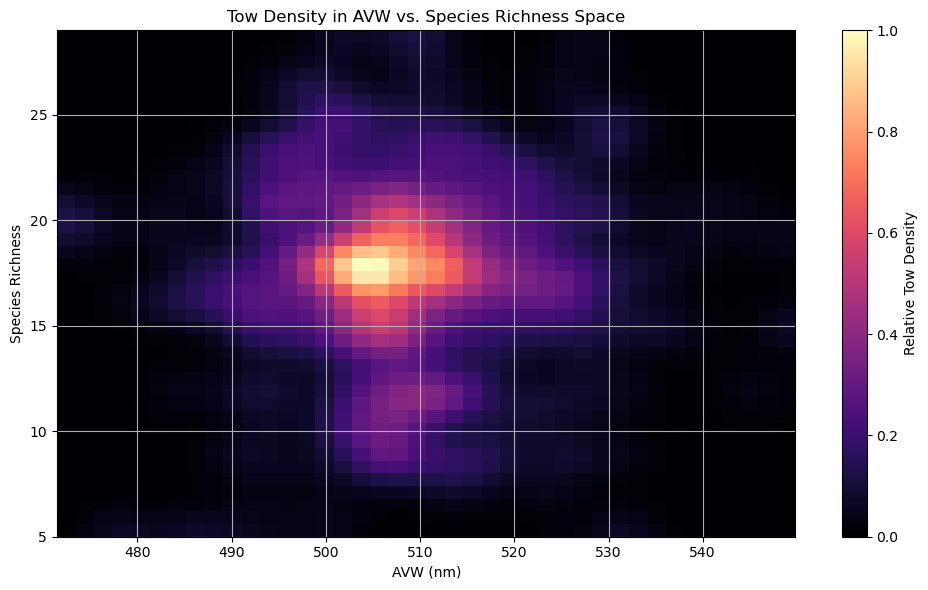

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter

# Identify species columns
# Step 1: Define metadata and Rrs columns
metadata_cols = ['TOWDATETIME_EST', 'LAT', 'LON', 'MEAN_DEPTH', 'AVW', 'SWEPT_AREA_KM']
rrs_cols = [col for col in df.columns if col.startswith("Rrs_")]

# Step 2: Define species columns *first*
species_cols = [col for col in df.columns if col not in metadata_cols + rrs_cols]

# Step 3: Convert them to numeric
df[species_cols] = df[species_cols].apply(pd.to_numeric, errors='coerce')

# Compute species richness (number of species present)
df["species_richness"] = (df[species_cols] > 0).sum(axis=1)

# Drop rows with missing values
subset = df[["AVW", "species_richness"]].dropna()
x = subset["AVW"]
y = subset["species_richness"]

# === 2D binning for point density ===
n_bins = 40
stat, xedges, yedges, _ = binned_statistic_2d(x, y, None, statistic='count', bins=n_bins)

# Replace NaNs with 0 and apply Gaussian smoothing
stat_filled = np.nan_to_num(stat, nan=0.0)
stat_smooth = gaussian_filter(stat_filled, sigma=1.5)

# Normalize for color scale
stat_normalized = stat_smooth / stat_smooth.max()

# Create meshgrid for plotting
X, Y = np.meshgrid(
    0.5 * (xedges[:-1] + xedges[1:]),
    0.5 * (yedges[:-1] + yedges[1:])
)

# === Plot heatmap ===
plt.figure(figsize=(10, 6))
pcm = plt.pcolormesh(X, Y, stat_normalized.T, cmap="magma", shading="auto")
plt.colorbar(pcm, label="Relative Tow Density")
plt.xlabel("AVW (nm)")
plt.ylabel("Species Richness")
plt.title("Tow Density in AVW vs. Species Richness Space")
plt.grid(True)
plt.tight_layout()
#plt.savefig("Species_richness.png", dpi=300)
plt.show()




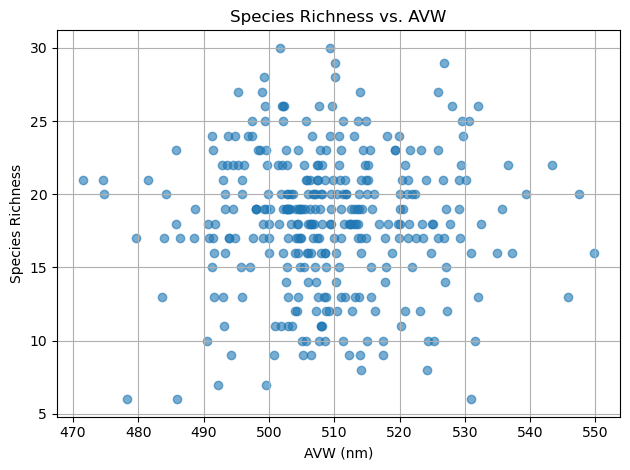

In [12]:
import matplotlib.pyplot as plt

# Identify species columns
# Step 1: Define metadata and Rrs columns
metadata_cols = ['TOWDATETIME_EST', 'LAT', 'LON', 'MEAN_DEPTH', 'AVW', 'SWEPT_AREA_KM']
rrs_cols = [col for col in df.columns if col.startswith("Rrs_")]

# Step 2: Define species columns *first*
species_cols = [col for col in df.columns if col not in metadata_cols + rrs_cols]

# Step 3: Convert them to numeric
df[species_cols] = df[species_cols].apply(pd.to_numeric, errors='coerce')

# Compute species richness (number of species present)
df["species_richness"] = (df[species_cols] > 0).sum(axis=1)

# Plot
plt.scatter(df["AVW"], df["species_richness"], alpha=0.6)
plt.xlabel("AVW (nm)")
plt.ylabel("Species Richness")
plt.title("Species Richness vs. AVW")
plt.grid(True)
plt.tight_layout()
plt.show()

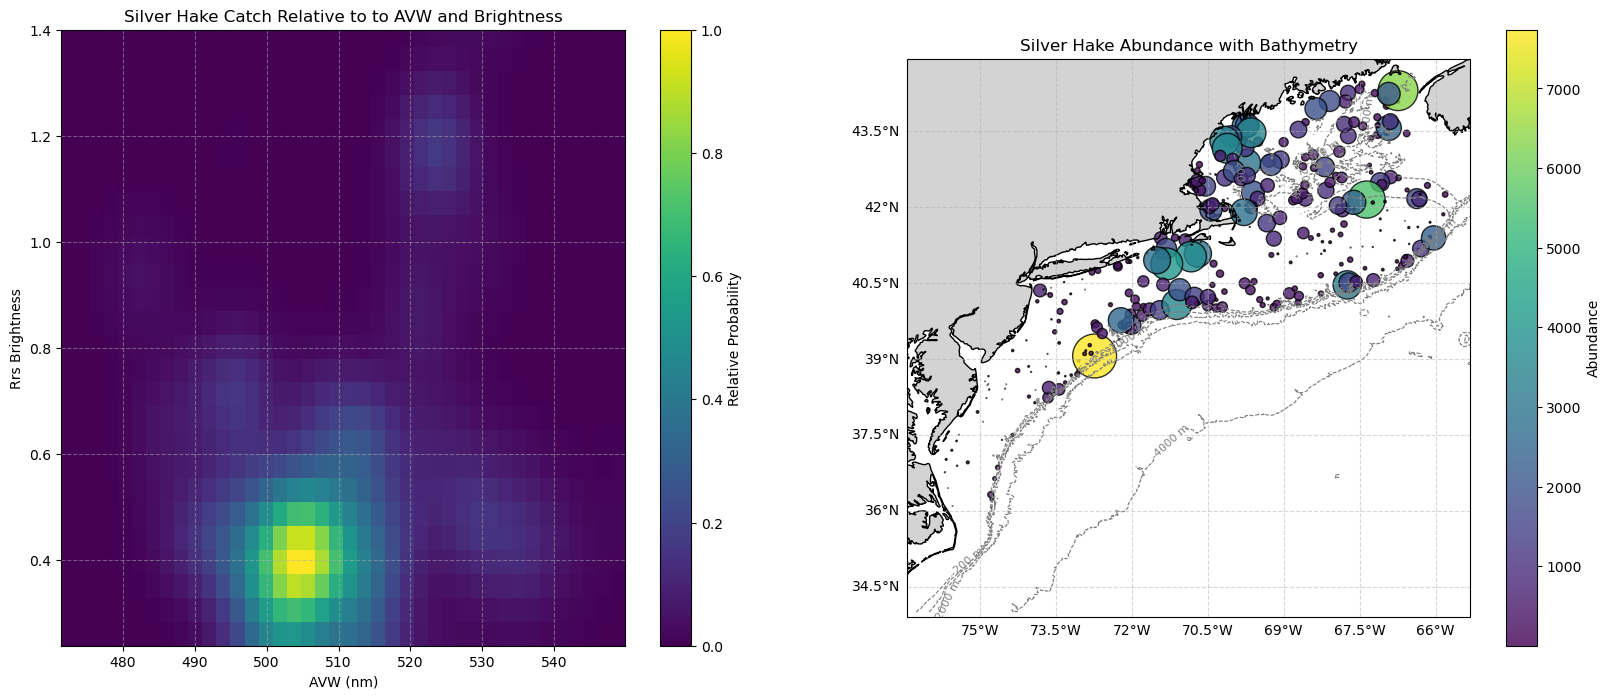

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

# === Choose your species ===
species = "silver hake"
species_filename = species.lower().replace(" ", "_")  # becomes 'longfin_squid'

# === 1. Preprocess for AVW vs. Rrs_brightness plot ===
subset1 = df[["AVW", "Rrs_brightness", species]].dropna()
x = subset1["AVW"]
y = subset1["Rrs_brightness"]
z = subset1[species]

n_bins = 40
stat, xedges, yedges, _ = binned_statistic_2d(x, y, z, statistic='sum', bins=n_bins)
stat_filled = np.nan_to_num(stat, nan=0.0)
stat_smooth = gaussian_filter(stat_filled, sigma=1.8)
stat_normalized = stat_smooth / stat_smooth.max()

X, Y = np.meshgrid(
    0.5 * (xedges[:-1] + xedges[1:]),
    0.5 * (yedges[:-1] + yedges[1:])
)

# === 2. Preprocess for map plot ===
subset2 = df[["LAT", "LON", species]].dropna()
subset2 = subset2[subset2[species] > 0]

size_scale = 1000
sizes = (subset2[species] / subset2[species].max()) * size_scale

# Load bathymetry data
gebco = xr.open_dataset("gebco_2024.nc")
lon_bathy = gebco["lon"]
lat_bathy = gebco["lat"]
depth = gebco["elevation"]

# Calculate extent based on species data
lat_min = df["LAT"].min() - 0.5
lat_max = df["LAT"].max() + 0.5
lon_min = df["LON"].min() - 0.5
lon_max = df["LON"].max() + 0.5

# === Create side-by-side figure ===
fig = plt.figure(figsize=(20, 8))

# === Left subplot: AVW vs Rrs Brightness ===
ax1 = fig.add_subplot(1, 2, 1)
p1 = ax1.pcolormesh(X, Y, stat_normalized.T, cmap="viridis", shading="auto")
ax1.set_xlabel("AVW (nm)")
ax1.set_ylabel("Rrs Brightness")
ax1.set_title(f"{species.title()} Catch Relative to to AVW and Brightness")
ax1.set_ylim(df["Rrs_brightness"].min(), 1.4)
ax1.grid(True, which='both', linestyle='--', alpha=0.5)
fig.colorbar(p1, ax=ax1, label="Relative Probability")

# === Right subplot: Map with Bathymetry ===
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

sc = ax2.scatter(
    subset2["LON"], subset2["LAT"], c=subset2[species],
    cmap="viridis", s=sizes, edgecolor="k", alpha=0.8,
    transform=ccrs.PlateCarree()
)

contour_levels = [-4000, -2000, -1000, -500, -200]
cs = ax2.contour(
    lon_bathy, lat_bathy, depth,
    levels=contour_levels, colors='gray', linewidths=0.8,
    transform=ccrs.PlateCarree()
)
ax2.clabel(cs, inline=True, fontsize=8, fmt='%d m')
ax2.coastlines()
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.set_title(f"{species.title()} Abundance with Bathymetry")

# Add gridlines and labels
gl = ax2.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}
# Optional: control tick spacing
# gl.xlocator = plt.MaxNLocator(5)
# gl.ylocator = plt.MaxNLocator(5)

fig.colorbar(sc, ax=ax2, label="Abundance")
#plt.savefig(f"{species_filename}_distribution.png", dpi=300)
plt.show()


In [4]:
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

#bbox = (-170.0, 20.0, -140.0, 35.0)
import xarray as xr
results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS",
    temporal = ("2024-04-01", "2024-04-30"),
    granule_name="*.MO.*.4km.*"
)
fileset = earthaccess.open(results);

results2 = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_AVW",
    temporal = ("2024-04-01", "2024-04-30"),
    granule_name="*.MO.*.4km.*"
)
fileset2 = earthaccess.open(results2);    

# ---- Load Libraries ----
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
from scipy.integrate import trapezoid

# Load relevant datasets
dataset = xr.open_dataset(fileset[0])
dataset2 = xr.open_dataset(fileset2[0])

# Assign core variables
latitude = dataset["lat"]
longitude = dataset["lon"]
Rrs = dataset["Rrs"]
wavelengths = dataset["wavelength"]
avw = dataset2["avw"]


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Define lat/lon bounds for your plot region
lat_bounds = [45.0, 34.0] 
lon_bounds = [-77.0, -65.0]

# Step 1: Subset spatially and spectrally (BEFORE .values)
Rrs_subset = Rrs.sel(
    lat=slice(*lat_bounds),
    lon=slice(*lon_bounds),
    wavelength=slice(400, 700)
)

avw_subset = avw.sel(
    lat=slice(*lat_bounds),
    lon=slice(*lon_bounds),
)

wl_subset = Rrs_subset["wavelength"].values  # shape: (n_wl,)

# Step 2: Convert to NumPy (now much smaller)
Rrs_np = Rrs_subset.values  # shape: (lat, lon, n_wl)

# Step 3: Integrate over wavelength (axis=2 now)
rrs_integrated = np.trapz(Rrs_np, x=wl_subset, axis=2)  # shape: (lat, lon)

rrs_integrated_da = xr.DataArray(
    rrs_integrated,
    coords={
        "lat": Rrs_subset["lat"],
        "lon": Rrs_subset["lon"]
    },
    dims=["lat", "lon"],
    name="rrs_integrated"
)

/tmp/ipykernel_98/1733027454.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rrs_integrated = np.trapz(Rrs_np, x=wl_subset, axis=2)  # shape: (lat, lon)


In [6]:
# === Apply filters ===
avw_mask = (avw_subset >= 497) & (avw_subset <= 512)
brightness_mask = (rrs_integrated_da >= 0.25) & (rrs_integrated_da <= 0.55)
valid_mask = avw_mask & brightness_mask

# Mask avw values for plotting
avw_filtered = avw.where(valid_mask)

# ---- Make product plot ----
#fig = plt.figure(figsize=(10, 5))
#ax = plt.axes(projection=cartopy.crs.PlateCarree())
#ax.gridlines(draw_labels={"bottom": "x", "left": "y"})
#ax.coastlines()

# ---- Adjust colorbar limits ----
#plot = dataset2["avw"].plot(x="lon", y="lat", cmap="jet", vmin=480, vmax=530)
#plot = avw_filtered.plot(x="lon", y="lat", cmap="jet", vmin=480, vmax=530)

# ---- Crop the image to preferred location ----
#plot.axes.set_xlim(-77.0,-65.0)
#plot.axes.set_ylim(34.0,45.0)

# ---- Customize colorbar label ----
#plot.colorbar.set_label("AVW (nm)", labelpad=10, fontsize=16, fontweight="bold")
#plt.title('')

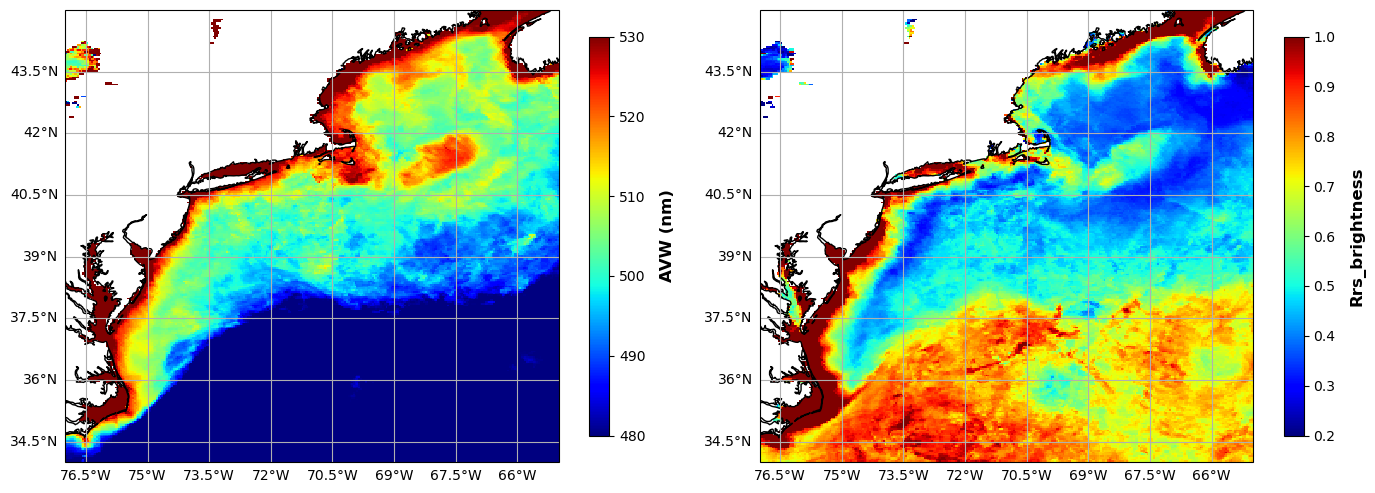

In [74]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Create 1 row, 2 columns of subplots with Cartopy projections
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6),
                         subplot_kw={'projection': ccrs.PlateCarree()})

# === Plot 1: AVW ===
ax1 = axes[0]
ax1.set_title("AVW")
ax1.coastlines()
ax1.gridlines(draw_labels={"bottom": "x", "left": "y"})
plot1 = dataset2["avw"].plot(
    ax=ax1, x="lon", y="lat", cmap="jet", vmin=480, vmax=530, add_colorbar=False
)
plot1.axes.set_xlim(-77.0, -65.0)
plot1.axes.set_ylim(34.0, 45.0)

# Add colorbar manually
cbar1 = fig.colorbar(plot1, ax=ax1, orientation="vertical", shrink=0.7)
cbar1.set_label("AVW (nm)", labelpad=10, fontsize=12, fontweight="bold")

# === Plot 2: Rrs_brightness ===
ax2 = axes[1]
ax2.set_title("Integrated Rrs Brightness")
ax2.coastlines()
ax2.gridlines(draw_labels={"bottom": "x", "left": "y"})
plot2 = rrs_integrated_da.plot(
    ax=ax2, x="lon", y="lat", cmap="jet", vmin=0.2, vmax=1.0, add_colorbar=False
)
plot2.axes.set_xlim(-77.0, -65.0)
plot2.axes.set_ylim(34.0, 45.0)

# Add colorbar manually
cbar2 = fig.colorbar(plot2, ax=ax2, orientation="vertical", shrink=0.7)
cbar2.set_label("Rrs_brightness", labelpad=10, fontsize=12, fontweight="bold")

# === Optional: Adjust layout ===
plt.tight_layout()
plt.savefig("AVW_brightness.png", dpi=300)

plt.show()


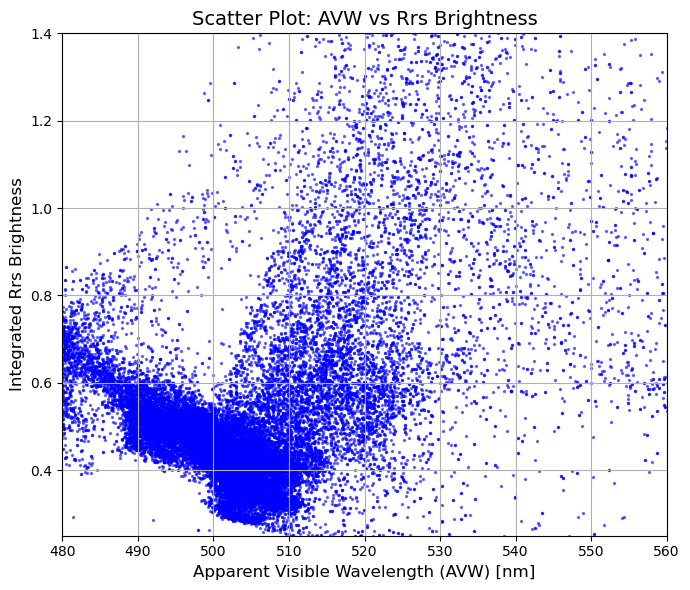

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# === Flatten the data and drop any NaNs ===
avw_flat = avw_subset.values.flatten()
rrs_flat = rrs_integrated_da.values.flatten()

# Mask invalid entries (where either is NaN)
valid_mask = np.isfinite(avw_flat) & np.isfinite(rrs_flat)

avw_clean = avw_flat[valid_mask]
rrs_clean = rrs_flat[valid_mask]

# === Make the scatter plot ===
plt.figure(figsize=(7, 6))
plt.scatter(avw_clean, rrs_clean, s=2, alpha=0.5, color="blue")
plt.axis([480, 560, 0.25, 1.4])

plt.xlabel("Apparent Visible Wavelength (AVW) [nm]", fontsize=12)
plt.ylabel("Integrated Rrs Brightness", fontsize=12)
plt.title("Scatter Plot: AVW vs Rrs Brightness", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


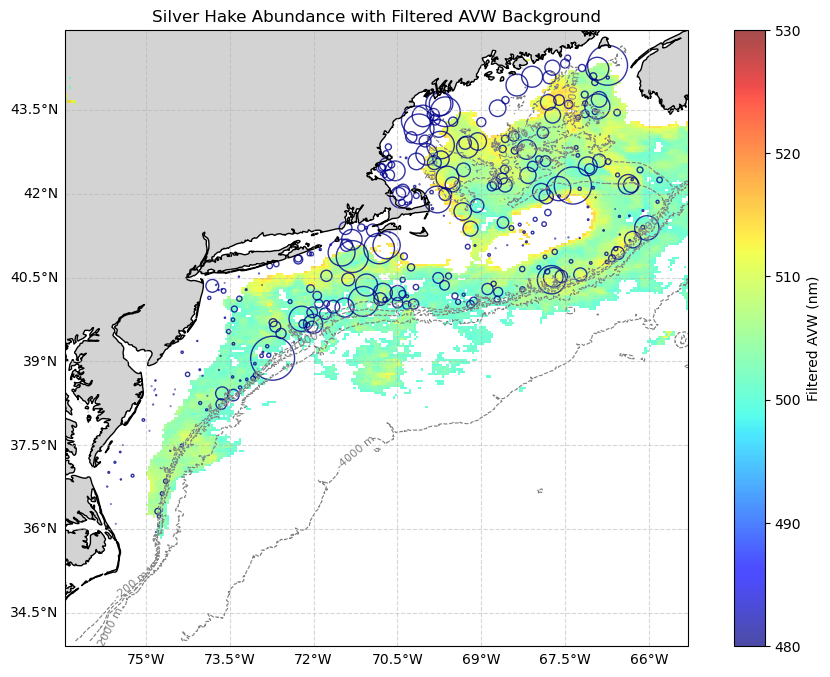

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming avw_filtered is an xarray.DataArray with dims ('lat', 'lon')

# === Apply filters ===
#vw_mask = (avw_subset >= 500) & (avw_subset <= 510) #longfin squid
#avw_mask = (avw_subset >= 498) & (avw_subset <= 510) #red hake
#avw_mask = (avw_subset >= 498) & (avw_subset <= 505) #spiny dogfish
#avw_mask = (avw_subset >= 500) & (avw_subset <= 520) #american lobster
#avw_mask = (avw_subset >=545) & (avw_subset <= 555) #alewife
#avw_mask = (avw_subset >= 500) & (avw_subset <= 510) #silver hake 
#avw_mask = (avw_subset >= 497) & (avw_subset <= 506) #spiny dogfish
avw_mask = (avw_subset >= 500) & (avw_subset <= 515) #red hake

#brightness_mask = (rrs_integrated_da >= 0.35) & (rrs_integrated_da <= 0.55)
#brightness_mask = (rrs_integrated_da >= 0.45) & (rrs_integrated_da <= 0.95)
#brightness_mask = (rrs_integrated_da >= 0.35) & (rrs_integrated_da <= 0.50)
#brightness_mask = (rrs_integrated_da >= 0.3) & (rrs_integrated_da <= 0.5)
#brightness_mask = (rrs_integrated_da >= 0.4) & (rrs_integrated_da <= 0.6)
#brightness_mask = (rrs_integrated_da >= 0.30) & (rrs_integrated_da <= 0.50)
#brightness_mask = (rrs_integrated_da >= 0.40) & (rrs_integrated_da <= 0.60)
brightness_mask = (rrs_integrated_da >= 0.25) & (rrs_integrated_da <= 0.56)

valid_mask = avw_mask & brightness_mask

# Mask avw values for plotting
avw_filtered = avw.where(valid_mask)


fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set extent to your data or desired bounding box
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot avw_filtered as a background image
# Use cmap and alpha for better overlay
im = avw_filtered.plot(
    ax=ax,
    x='lon',
    y='lat',
    cmap='jet',
    vmin=480,
    vmax=530,
    alpha=0.7,
    add_colorbar=True,
    cbar_kwargs={'label': 'Filtered AVW (nm)'}
)

# Plot bathymetry contours as before
contour_levels = [-4000, -2000, -1000, -500, -200]
cs = ax.contour(
    lon_bathy, lat_bathy, depth,
    levels=contour_levels, colors='gray', linewidths=0.8,
    transform=ccrs.PlateCarree()
)
ax.clabel(cs, inline=True, fontsize=8, fmt='%d m')

ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Scatter points with fixed color (e.g., dark blue), but sizes scaled by abundance
scatter = ax.scatter(
    subset2["LON"], subset2["LAT"],
    s=sizes,
    facecolors='none',   # no fill
    edgecolor='darkblue', # outline color
    alpha=0.8,
    transform=ccrs.PlateCarree(),
    label=species.title()
)

# Gridlines and labels
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}

ax.set_title(f"{species.title()} Abundance with Filtered AVW Background")

# Add legend for size (optional):
# You can create a legend manually if you want to indicate size meaning
plt.savefig(f"{species_filename}_filtered2.png", dpi=300)
plt.show()


/tmp/ipykernel_567/2631591294.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["brightness_bin"] = pd.cut(df["Rrs_brightness"], bins=bin_edges)
/tmp/ipykernel_567/2631591294.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  presence["brightness_bin"] = df["brightness_bin"]
/tmp/ipykernel_567/2631591294.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and

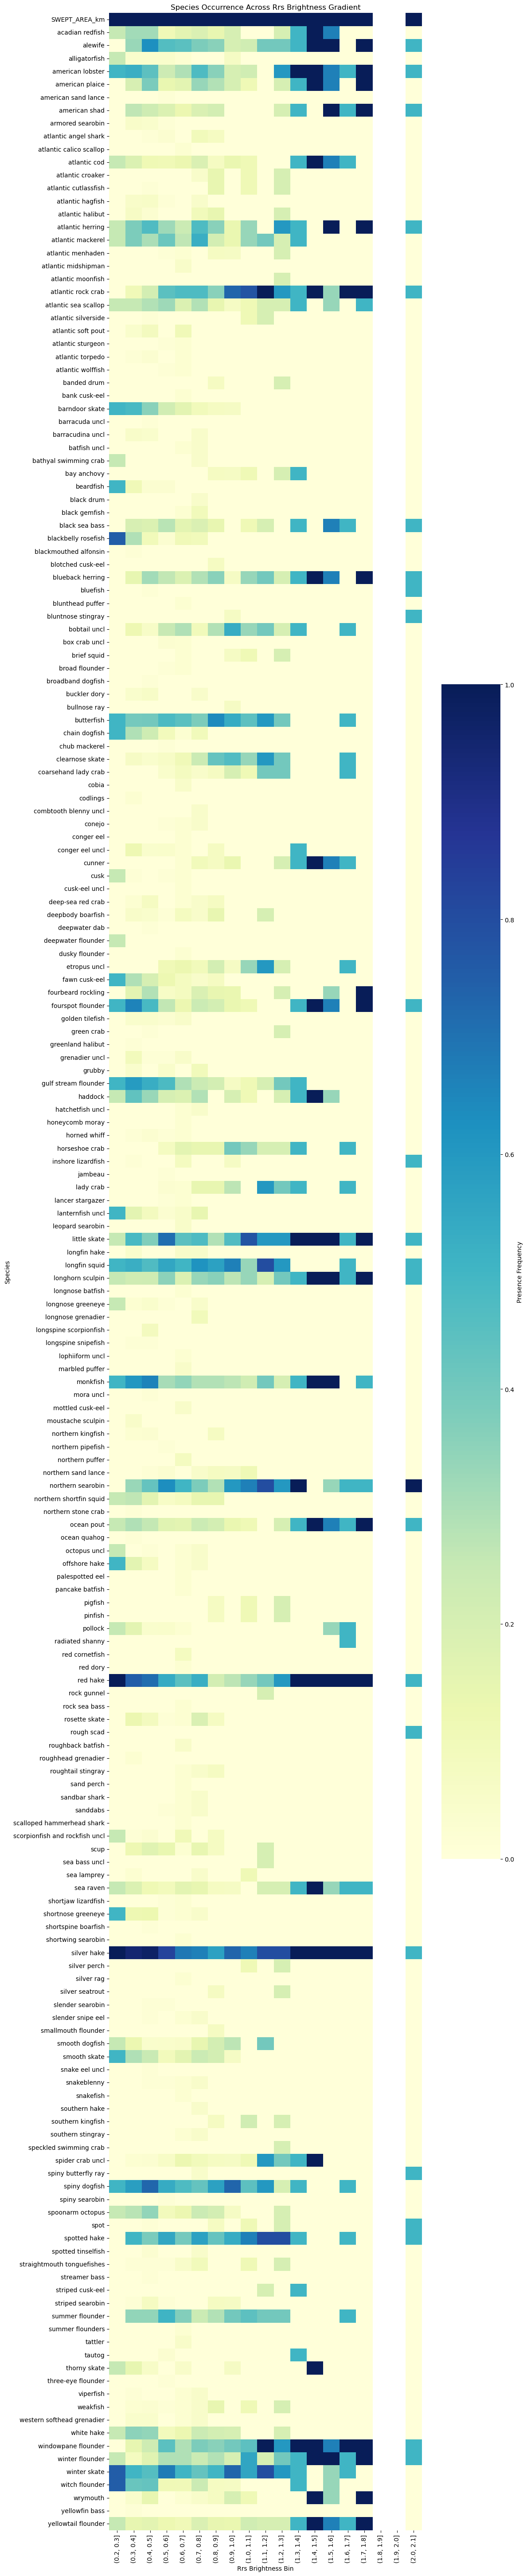

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Create bins of width 0.1 across the observed Rrs_brightness range
min_val = df["Rrs_brightness"].min()
max_val = df["Rrs_brightness"].max()
bin_edges = np.arange(np.floor(min_val*10)/10, np.ceil(max_val*10)/10 + 0.1, 0.1)

# Assign bin labels
df["brightness_bin"] = pd.cut(df["Rrs_brightness"], bins=bin_edges)

# Compute mean presence per bin
presence = df[species_cols] > 0
presence["brightness_bin"] = df["brightness_bin"]
heatmap_df = presence.groupby("brightness_bin").mean()

# Plot
n_species = len(species_cols)
fig_height = max(6, n_species * 0.3)

plt.figure(figsize=(12, fig_height))
sns.heatmap(heatmap_df.T, cmap="YlGnBu", cbar_kws={"label": "Presence Frequency"})
plt.title("Species Occurrence Across Rrs Brightness Gradient")
plt.xlabel("Rrs Brightness Bin")
plt.ylabel("Species")
plt.tight_layout()
plt.show()


/tmp/ipykernel_567/3597398891.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["AVW_bin"] = pd.cut(df["AVW"], bins=10)
/tmp/ipykernel_567/3597398891.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  presence["AVW_bin"] = df["AVW_bin"]
/tmp/ipykernel_567/3597398891.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_df = pre

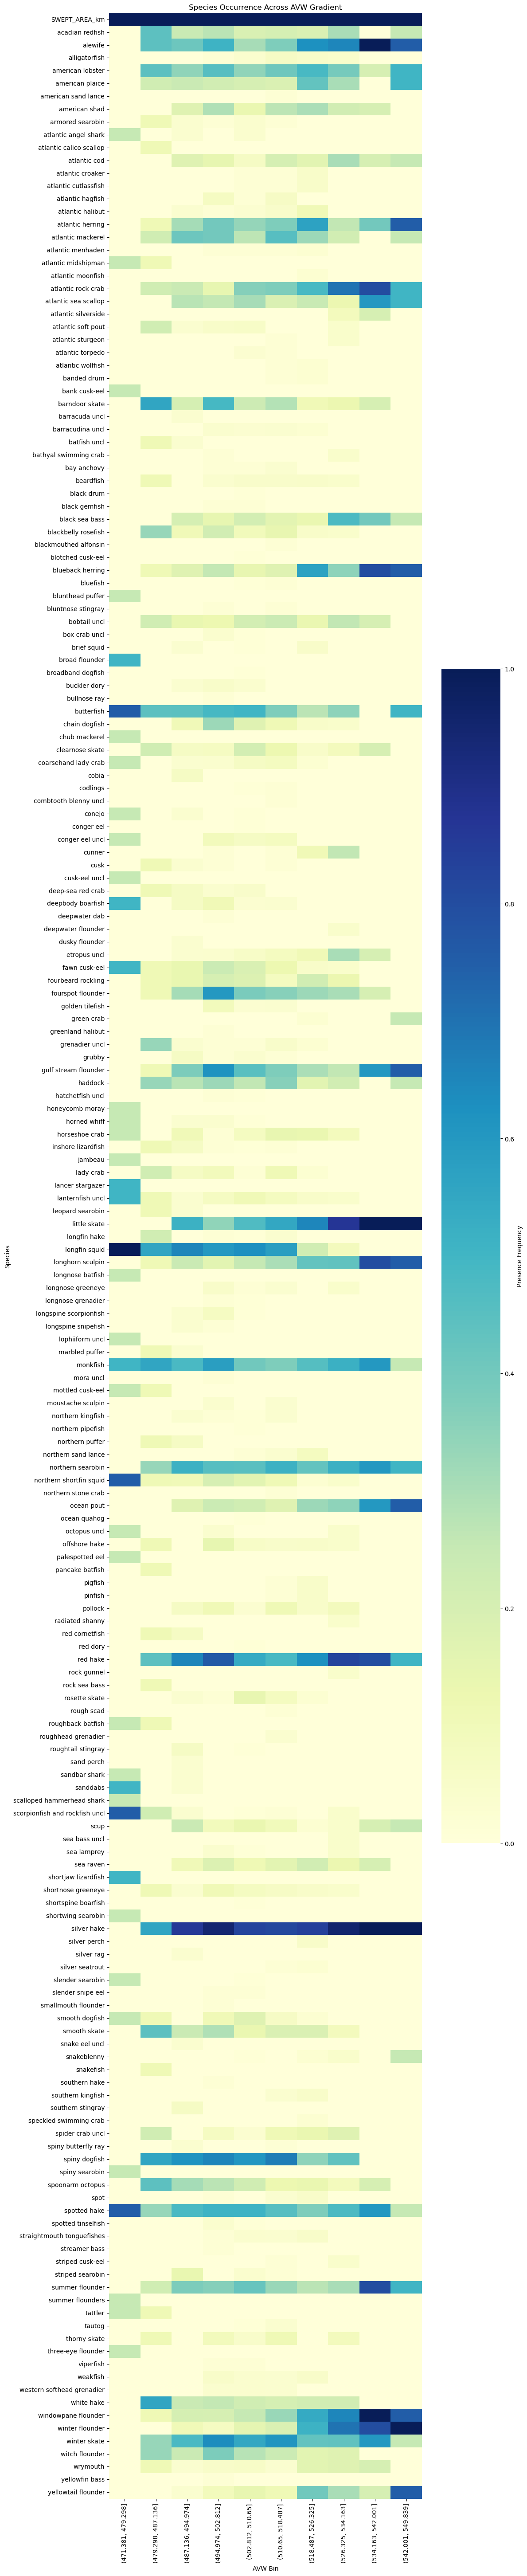

In [5]:
import seaborn as sns
import numpy as np

# Bin AVW values
df["AVW_bin"] = pd.cut(df["AVW"], bins=10)

# Compute mean presence per bin
presence = df[species_cols] > 0
presence["AVW_bin"] = df["AVW_bin"]
heatmap_df = presence.groupby("AVW_bin").mean()

# Number of species to help scale the figure height
n_species = len(species_cols)

# Adjust figure height based on number of species (e.g., 0.3 inches per species)
fig_height = max(6, n_species * 0.3)

plt.figure(figsize=(12, fig_height))
sns.heatmap(heatmap_df.T, cmap="YlGnBu", cbar_kws={"label": "Presence Frequency"})
plt.title("Species Occurrence Across AVW Gradient")
plt.xlabel("AVW Bin")
plt.ylabel("Species")
plt.tight_layout()
plt.show()

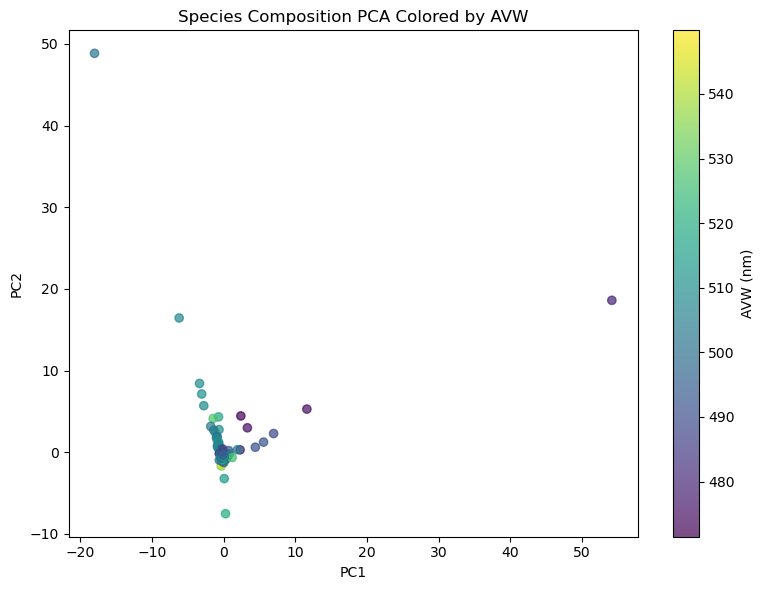

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Normalize abundance data
X = df[species_cols].fillna(0).values
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

# Plot with AVW color scale
plt.figure(figsize=(8,6))
plt.scatter(components[:,0], components[:,1], c=df["AVW"], cmap='viridis', alpha=0.7)
plt.colorbar(label="AVW (nm)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Species Composition PCA Colored by AVW")
plt.tight_layout()
plt.show()


/tmp/ipykernel_205/7219896.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x="Species", y="AVW", data=melted, inner="box", scale="width")


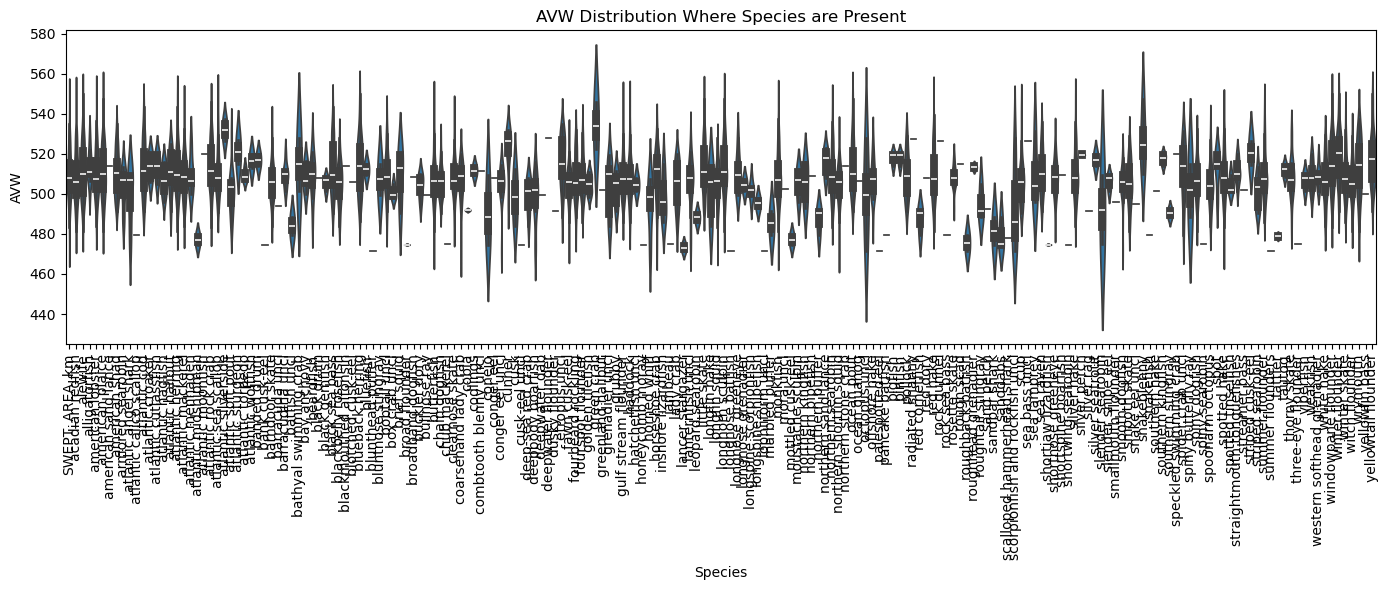

In [5]:
melted = df.melt(id_vars=["AVW"], value_vars=species_cols,
                 var_name="Species", value_name="Abundance")
melted = melted[melted["Abundance"] > 0]

plt.figure(figsize=(14, 6))
sns.violinplot(x="Species", y="AVW", data=melted, inner="box", scale="width")
plt.xticks(rotation=90)
plt.title("AVW Distribution Where Species are Present")
plt.tight_layout()
plt.show()
